# Conditional Normalizing Flow Model

Here, we train a conditional normalizing flow model $q(x|c)$. Our target $p(x|c)$ is a simple 2D Gaussian $\mathcal{N}(x|\mu, \sigma)$, where we condition on the mean $\mu$ and standard deviation $\sigma$, i.e. $c = (\mu, \sigma)$. We apply conditional autoregressive and coupling neural spline flows as well as a conditional masked autoregressive flow to the problem.

## Workflow
0. Before working in this notebook, you must first run simulations and the preprocess the data as it takes way too long to do interactively.
    1. For simulating data, see work_eic/slurm/makeJobs*
    1. for preprocessing the data see work_eic/macros/Time_estimation/slurm/
    1. These use the slurm batch system to run on the dcc
    1. Once you have run these, you should have a few .pt files that contain tensors that can be read into this notebook
    1. These tensors should have 5 values, the first four being context and the last being the time value which is the feature
1. Load in the data and shuffle it to ensure data is randomly distributed in dataset; then separate into train and test sets
2. Define model
    1. Right now the autoregressive neural spline model seems to work well
    1. We have used masked affine coupling models before in the past but this doesn't seem like it would make sense here as we only have 1 feature and hence cannot mask it
3. Train the model with the training loop (unless you already have a pretrained model)
4. Save the model (or load)
5. Generate samples based on the context of your test dataset
6. Plot timing distribution
    7. The test distribution should match the sampled distribution pretty well since the samples are drawn from the same context as the test data

## Setup

In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from util import PVect, theta_func, r_func
from IPython.display import clear_output


Using device cuda:0


In [2]:
import os
def checkdir(path):
    if not os.path.exists(path): 
        os.makedirs(path)

In [3]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Data preparation
Need 5 features:
1. Four conditionals:
    1. Hit z position (calculate from shoot position and angle)
    2. mu incident time on scint (calculate from momentum and distance)
    3. hit theta (calculate from momentum vector)
    4. hit momenta (calculate from momentum vector)
2. Feature
    1. photon hit time on sensor

##### Status
1. Hit z, hit theta, hit momenta and photon hit time are all good
1. Just need to calculate hit time from momentum (velocity) and distance traveled (use pythogorean theorem with x and z)

### Preprocess manually below if not loading data

### Load data from .pt file (created by preprocess.py)

In [6]:
# Timing_path = "/cwork/rck32/eic/work_eic/macros/Timing_estimation/"

# inputs = torch.load(Timing_path + "data/July_04/Run_0/Vary_p_2000events_file_0_w_cuts.pt")
# for i in range(1,18):
#     inputs = torch.cat((inputs, torch.load(Timing_path + f"data/July_04/Run_0/Vary_p_2000events_file_{i}_w_cuts.pt")),0)

July 5th 50 z pos set:

In [7]:
# Timing_path = "/cwork/rck32/eic/work_eic/macros/Timing_estimation/"
# inputs = torch.load(Timing_path + "data/July_05/Run_0/Vary_p_2000events_file_0_July_5_50_z_pos.pt")
# for i in range(1,51):
#     inputs = torch.cat((inputs, torch.load(Timing_path + f"data/July_05/Run_0/Vary_p_2000events_file_{i}_July_5_50_z_pos.pt")),0)

July 18th 200 z pos set: 

In [ ]:
# Timing_path = "/cwork/rck32/eic/work_eic/macros/Timing_estimation/"

# raw_inputs = torch.load(Timing_path + "data/July_21/Run_1/Vary_p_events_file_0_July_19_200_z_pos.pt")
# for i in range(1,201):
#     raw_inputs = torch.cat((raw_inputs, torch.load(Timing_path + f"data/July_21/Run_1/Vary_p_events_file_{i}_July_19_200_z_pos.pt")),0)

July 23rd 600 z pos set: 

In [5]:
Timing_path = "/cwork/rck32/eic/work_eic/macros/Timing_estimation/"

In [11]:
raw_inputs = torch.load(Timing_path + "data/July_24/Run_1/Vary_p_events_file_0_July_23_600_z_pos.pt")
for i in range(600):
    clear_output(wait=True)
    print(f"loaded file #{i+1} of 600")
    raw_inputs = torch.cat((raw_inputs, torch.load(Timing_path + f"data/July_24/Run_1/Vary_p_events_file_{i+1}_July_23_600_z_pos.pt")),0)

loaded file #600 of 600


In [12]:
raw_inputs.shape

torch.Size([513132162, 5])

In [13]:
inputs = raw_inputs[np.logical_and(raw_inputs[:,4] < 100,raw_inputs[:,3] < 0.06)]

/tmp/ipykernel_3728697/2075640514.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  inputs = raw_inputs[np.logical_and(raw_inputs[:,4] < 100,raw_inputs[:,3] < 0.06)]


In [14]:
indexes = torch.randperm(inputs.shape[0])
dataset = inputs[indexes]
train_frac = 0.008
test_frac = 0.001
val_frac = 0.001
train_lim = int(np.floor(dataset.shape[0] * train_frac))
test_lim = train_lim + int(np.floor(dataset.shape[0] * test_frac))
val_lim = test_lim + int(np.floor(dataset.shape[0] * val_frac))
train_data = dataset[:train_lim]
test_data = dataset[train_lim:test_lim]
val_data = dataset[test_lim:val_lim]

In [17]:
train_data.shape

torch.Size([4098709, 5])

In [22]:
train_data = torch.load(Timing_path + "data/combined/July_23/tenth_600_z_pos_train.pt")
test_data = torch.load(Timing_path + "data/combined/July_23/tenth_600_z_pos_test.pt")
val_data = torch.load(Timing_path + "data/combined/July_23/tenth_600_z_pos_val.pt")

uncut: 110166 for 0.001 fraction

sensor time cut: 110155

both cuts: 110114

tighter incident cut (0.06): 110022

In [ ]:
fig, axs = plot.subplots(3,2,figsize = (9,14))
fig.suptitle("test_data 200 z vals")
axs[0,0].hist(test_data[:,0],bins = 1000);
axs[0,0].set_title("hit z pos")
axs[0,0].set_xlabel("mm")

axs[0,1].hist(test_data[:,1],bins = 500);
axs[0,1].set_title("gun theta")
axs[0,1].set_xlabel("theta (degrees)")


axs[1,0].hist(test_data[:,2],bins = 500);
axs[1,0].set_title("mu momentum")
axs[1,0].set_xlabel("(GeV/c)")

axs[1,1].hist(test_data[:,3],bins = 500)
axs[1,1].set_title("mu hit incident time")
axs[1,1].set_xlabel("(ns)")


N, bins, patches = axs[2,1].hist(test_data[:,4],bins = 500)
axs[2,1].set_title("sensor hit times")
axs[2,1].set_xlabel("(ns)")

In [55]:
fig.savefig("plots/inputs/july_21_run_1_sensor_time_incident_time_cuts.pdf")

## Masked Autoregressive Flow

### Model specification

In [13]:
# # Define flows
# K = 4

# latent_size = 1
# hidden_units = 128
# num_blocks = 2
# context_size = 4

# flows = []
# for i in range(K):
#     flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden_units, 
#                                                   context_features=context_size, 
#                                                   num_blocks=num_blocks)]
#     flows += [nf.flows.LULinearPermute(latent_size)]

# # Set base distribution
# q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# # Construct flow model
# model = nf.ConditionalNormalizingFlow(q0, flows)

# # Move model on GPU if available
# model = model.to(device)

## Neural Spline Flow

In [14]:
# Define flows
run_num = 11
run_num_str = str(run_num)

In [25]:
K = 4

latent_size = 1
hidden_units = 128
hidden_layers = 20
context_size = 3
num_context = 3
batch_size= 2000
lr = 1e-5

lr_str = str(lr)
K_str = str(K)
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)
num_context_str = str(num_context)
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)

Create necessary directories

In [16]:
import datetime

x = datetime.datetime.now()
today = x.strftime("%B_%d")
# model_path = "models/context_3/" + today + "/"
# checkdir(model_path)

model_path = "models/" + today + "/"
checkdir(model_path)

loss_path = "plots/loss/" + today + "/"
checkdir(loss_path)

test_data_path = "data/test/" + today + "/"
checkdir(test_data_path)


In [17]:
run_info = "run_" + run_num_str+"_"+num_context_str+ "context_"+ K_str + "flows_" + hidden_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs"

### Training

#### Original loop with 4 context params

In [31]:
# # Train model

# num_context = 4
# num_epochs = 1
# max_iter = int(np.floor(train_data.shape[0] / batch_size))

# loss_hist = np.array([])

# optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
# for epoch in range(num_epochs):
#     print(f"Beginning epoch #{epoch}")
#     for it in tqdm(range(max_iter)):
#         optimizer.zero_grad()

#         # Get training samples
#         begin = it * batch_size
#         end = (it + 1) * batch_size
#         it_data = train_data[begin:end]
#         context = it_data[:,:num_context].to(device)
#         samples = it_data[:,num_context].unsqueeze(1).to(device)

#         # Compute loss
#         loss = model.forward_kld(samples, context)

#         # Do backprop and optimizer step
#         if ~(torch.isnan(loss) | torch.isinf(loss)):
#             loss.backward()
#             optimizer.step()

#         # Log loss
#         loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

#### Loop with 3 context params

In [32]:
# # Train model

# num_context = 4
# num_epochs = 1
# max_iter = int(np.floor(train_data.shape[0] / batch_size))

# loss_hist = np.array([])

# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# for epoch in range(num_epochs):
#     print(f"Beginning epoch #{epoch}")
#     for it in tqdm(range(max_iter)):
#         optimizer.zero_grad()

#         # Get training samples
#         begin = it * batch_size
#         end = (it + 1) * batch_size
#         it_data = train_data[begin:end]
#         context = torch.empty(it_data.size()[0],3)
#         context[:,0] = it_data[:,0]
#         context[:,1] = it_data[:,1]
#         context[:,2] = it_data[:,2]
#         context = context.to(device)
# #         context = it_data[:,:num_context].to(device)
#         samples = (it_data[:,4] - it_data[:,3]).unsqueeze(1).to(device)

#         # Compute loss
#         loss = model.forward_kld(samples, context)

#         # Do backprop and optimizer step
#         if ~(torch.isnan(loss) | torch.isinf(loss)):
#             loss.backward()
#             optimizer.step()

#         # Log loss
#         loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

#### Train with Validation

In [ ]:
# Train model
num_context = 4
num_epochs = 12
max_iter = int(np.floor(train_data.shape[0] / batch_size))
train_loss_hist = np.array([])
val_loss_hist = np.array([])
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

validation_frequency = 2000  # Perform validation every 100 training steps
running_loss = 0
global_step = 0
for epoch in range(num_epochs):
    print(f"Beginning epoch #{epoch}")
    model.train()  # Set model to training mode
    for it in tqdm(range(max_iter)):
        optimizer.zero_grad()
        # Get training samples
        begin = it * batch_size
        end = (it + 1) * batch_size
        it_data = train_data[begin:end]
        context = torch.empty(it_data.size()[0], 3)
        context[:,0] = it_data[:,0]
        context[:,1] = it_data[:,1]
        context[:,2] = it_data[:,2]
        context = context.to(device)
        samples = (it_data[:,4] - it_data[:,3]).unsqueeze(1).to(device)
        # Compute loss
        loss = model.forward_kld(samples, context)
        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        # Log loss
        train_loss_hist = np.append(train_loss_hist, loss.to('cpu').data.numpy())
        running_loss += loss.to('cpu').data.numpy()
        global_step += 1

        # Validation step every 100 training steps
        if global_step % validation_frequency == 0:
            model.eval()  # Set model to evaluation mode
            val_loss = 0
            val_iter = min(100, int(np.floor(val_data.shape[0] / batch_size)))  # Limit validation to 100 batches
            with torch.no_grad():
                for val_it in range(val_iter):
                    begin = val_it * batch_size
                    end = (val_it + 1) * batch_size
                    it_data = val_data[begin:end]
                    context = torch.empty(it_data.size()[0], 3)
                    context[:,0] = it_data[:,0]
                    context[:,1] = it_data[:,1]
                    context[:,2] = it_data[:,2]
                    context = context.to(device)
                    samples = (it_data[:,4] - it_data[:,3]).unsqueeze(1).to(device)
                    loss = model.forward_kld(samples, context)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / val_iter
            print(f"train_loss: {running_loss / validation_frequency}\nval_loss: {avg_val_loss}")
            val_loss_hist = np.append(val_loss_hist, avg_val_loss)
            
#             print(f"Step {global_step} - Train Loss: {train_loss_hist[-1]:.4f}, Val Loss: {avg_val_loss:.4f}")
            
            model.train()  # Set model back to training mode
            running_loss = 0
    model.save(model_path + run_info + f"_checkpoint_e{epoch}.pth")
    print(f"Epoch {epoch} completed.")

Beginning epoch #0


 10%|▉         | 2001/20461 [03:18<2:04:01,  2.48it/s]

train_loss: 588.2662257385253
val_loss: 27.29391571044922


 20%|█▉        | 4001/20461 [06:48<3:00:03,  1.52it/s]

train_loss: 524.1111487388611
val_loss: 24.389922122955323


 29%|██▉       | 6001/20461 [10:17<2:33:53,  1.57it/s]

train_loss: 467.1963185119629
val_loss: 21.804510288238525


 39%|███▉      | 8001/20461 [13:40<1:23:58,  2.47it/s]

train_loss: 415.98923503875733
val_loss: 19.469373302459715


 49%|████▉     | 10001/20461 [16:54<1:10:56,  2.46it/s]

train_loss: 369.9758038520813
val_loss: 17.373091201782227


 59%|█████▊    | 12001/20461 [20:18<1:24:41,  1.66it/s]

train_loss: 328.1427126598358
val_loss: 15.48888162612915


 68%|██████▊   | 14001/20461 [23:38<50:54,  2.11it/s]  

train_loss: 290.8952839374542
val_loss: 13.808169431686402


 78%|███████▊  | 16001/20461 [26:53<34:04,  2.18it/s]

train_loss: 257.8267047786713
val_loss: 12.314872436523437


 88%|████████▊ | 18001/20461 [30:10<18:33,  2.21it/s]

train_loss: 228.70584074020385
val_loss: 10.95435486793518


 98%|█████████▊| 20001/20461 [33:15<03:27,  2.22it/s]

train_loss: 204.97397027969362
val_loss: 9.73996332168579


100%|██████████| 20461/20461 [33:54<00:00, 10.06it/s]


Epoch 0 completed.
Beginning epoch #1


  8%|▊         | 1540/20461 [02:15<1:58:01,  2.67it/s]

train_loss: 186.17056531906127
val_loss: 8.65466576576233


 17%|█▋        | 3540/20461 [05:10<1:52:00,  2.52it/s]

train_loss: 165.68788954734802
val_loss: 7.699469103813171


 27%|██▋       | 5540/20461 [08:05<1:51:02,  2.24it/s]

train_loss: 146.95375458717345
val_loss: 6.86425518989563


 37%|███▋      | 7541/20461 [11:06<1:11:28,  3.01it/s]

train_loss: 130.6445038986206
val_loss: 6.138702363967895


 47%|████▋     | 9541/20461 [14:06<1:01:13,  2.97it/s]

train_loss: 116.51909138202667
val_loss: 5.4954609251022335


 56%|█████▋    | 11540/20461 [17:06<1:04:35,  2.30it/s]

train_loss: 104.34937509059905
val_loss: 4.950885114669799


 66%|██████▌   | 13540/20461 [20:06<52:27,  2.20it/s]  

train_loss: 93.7064199590683
val_loss: 4.473707232475281


 76%|███████▌  | 15540/20461 [23:09<46:52,  1.75it/s]

train_loss: 84.7548513674736
val_loss: 4.064685595035553


 86%|████████▌ | 17540/20461 [26:04<22:21,  2.18it/s]

train_loss: 77.01318483352661
val_loss: 3.7197865939140318


 95%|█████████▌| 19540/20461 [29:08<05:57,  2.58it/s]

train_loss: 71.07553532838821
val_loss: 3.428473718166351


100%|██████████| 20461/20461 [30:31<00:00, 11.17it/s]


Epoch 1 completed.
Beginning epoch #2


  5%|▌         | 1079/20461 [01:35<2:24:17,  2.24it/s]

train_loss: 66.40118921756745
val_loss: 3.1841002702713013


 15%|█▌        | 3079/20461 [04:27<2:06:24,  2.29it/s]

train_loss: 62.252408220767975
val_loss: 2.9944064950942995


 25%|██▍       | 5079/20461 [07:31<1:36:19,  2.66it/s]

train_loss: 58.590928411483766
val_loss: 2.836214911937714


 35%|███▍      | 7079/20461 [10:29<1:37:12,  2.29it/s]

train_loss: 55.72104483366012
val_loss: 2.717701210975647


 44%|████▍     | 9080/20461 [13:24<1:03:51,  2.97it/s]

train_loss: 53.307067148685455
val_loss: 2.6042673063278197


 54%|█████▍    | 11079/20461 [16:19<59:55,  2.61it/s]  

train_loss: 51.28416574001312
val_loss: 2.51684623003006


 64%|██████▍   | 13079/20461 [19:14<54:50,  2.24it/s]

train_loss: 49.771692070960995
val_loss: 2.4557415294647216


 74%|███████▎  | 15079/20461 [22:10<35:00,  2.56it/s]

train_loss: 48.55177183628082
val_loss: 2.400255880355835


 83%|████████▎ | 17079/20461 [25:07<21:18,  2.64it/s]

train_loss: 47.544215240478515
val_loss: 2.3587447714805605


 93%|█████████▎| 19079/20461 [28:08<10:27,  2.20it/s]

train_loss: 46.898601655960086
val_loss: 2.3263570713996886


100%|██████████| 20461/20461 [30:10<00:00, 11.30it/s]


Epoch 2 completed.
Beginning epoch #3


  3%|▎         | 618/20461 [00:57<2:25:21,  2.28it/s]

train_loss: 46.33259487628937
val_loss: 2.3043869495391847


 13%|█▎        | 2619/20461 [03:59<1:42:41,  2.90it/s]

train_loss: 46.0157259964943
val_loss: 2.2823167514801024


 23%|██▎       | 4618/20461 [07:01<2:10:30,  2.02it/s]

train_loss: 45.550505871772764
val_loss: 2.2665124797821044


 32%|███▏      | 6618/20461 [09:59<1:43:17,  2.23it/s]

train_loss: 45.287056062221524
val_loss: 2.2562190246582032


 42%|████▏     | 8618/20461 [12:53<1:27:02,  2.27it/s]

train_loss: 44.95730283737183
val_loss: 2.238454513549805


 52%|█████▏    | 10618/20461 [15:53<1:38:18,  1.67it/s]

train_loss: 44.74547464132309
val_loss: 2.227397267818451


 62%|██████▏   | 12618/20461 [18:51<57:01,  2.29it/s]  

train_loss: 44.545075340271
val_loss: 2.218651113510132


 71%|███████▏  | 14618/20461 [21:49<1:00:22,  1.61it/s]

train_loss: 44.43669801950455
val_loss: 2.215964334011078


 81%|████████  | 16618/20461 [24:44<24:27,  2.62it/s]  

train_loss: 44.255585231781005
val_loss: 2.211850938796997


 91%|█████████ | 18618/20461 [27:40<13:26,  2.28it/s]

train_loss: 44.17168122053146
val_loss: 2.2223275017738344


100%|██████████| 20461/20461 [30:23<00:00, 11.22it/s]


Epoch 3 completed.
Beginning epoch #4


  1%|          | 157/20461 [00:16<3:00:04,  1.88it/s]

train_loss: 44.1597367143631
val_loss: 2.206465995311737


 11%|█         | 2157/20461 [03:11<1:55:05,  2.65it/s]

train_loss: 44.19886574983597
val_loss: 2.2000826740264894


 20%|██        | 4157/20461 [06:08<2:00:34,  2.25it/s]

train_loss: 44.17277563810349
val_loss: 2.200572459697723


 30%|███       | 6157/20461 [09:09<1:53:51,  2.09it/s]

train_loss: 44.081391835212706
val_loss: 2.1996523213386534


 40%|███▉      | 8157/20461 [12:05<1:30:05,  2.28it/s]

train_loss: 44.03997158527374
val_loss: 2.195691957473755


 50%|████▉     | 10157/20461 [15:03<1:16:16,  2.25it/s]

train_loss: 44.1029560136795
val_loss: 2.1989102864265444


 59%|█████▉    | 12157/20461 [18:01<1:03:06,  2.19it/s]

train_loss: 43.97744254589081
val_loss: 2.1942938327789308


 69%|██████▉   | 14157/20461 [21:02<40:55,  2.57it/s]  

train_loss: 43.9185772061348
val_loss: 2.1920172905921937


 79%|███████▉  | 16157/20461 [23:57<32:33,  2.20it/s]

train_loss: 43.878264467716214
val_loss: 2.1925814008712767


 89%|████████▊ | 18157/20461 [26:51<14:35,  2.63it/s]

train_loss: 43.847935106754306
val_loss: 2.1931957983970642


 99%|█████████▊| 20157/20461 [29:52<02:53,  1.75it/s]

train_loss: 43.84932809591293
val_loss: 2.1912795066833497


100%|██████████| 20461/20461 [30:19<00:00, 11.25it/s]


Epoch 4 completed.
Beginning epoch #5


  8%|▊         | 1696/20461 [02:30<2:18:50,  2.25it/s]

train_loss: 44.17160398244858
val_loss: 2.1953781914710997


 18%|█▊        | 3696/20461 [05:27<2:45:01,  1.69it/s]

train_loss: 44.04125742912292
val_loss: 2.1925471091270445


 28%|██▊       | 5696/20461 [08:32<1:35:23,  2.58it/s]

train_loss: 43.94450345516205
val_loss: 2.191093306541443


 38%|███▊      | 7696/20461 [11:34<1:20:47,  2.63it/s]

train_loss: 43.927258696556095
val_loss: 2.188975691795349


 47%|████▋     | 9696/20461 [14:35<1:22:01,  2.19it/s]

train_loss: 43.90715441942215
val_loss: 2.1881197094917297


 57%|█████▋    | 11696/20461 [17:37<1:16:03,  1.92it/s]

train_loss: 43.884040310382844
val_loss: 2.1864812397956848


 67%|██████▋   | 13696/20461 [20:34<52:19,  2.15it/s]  

train_loss: 43.84103363513947
val_loss: 2.186011061668396


 77%|███████▋  | 15696/20461 [23:27<31:01,  2.56it/s]

train_loss: 43.79845858335495
val_loss: 2.1856180000305176


 86%|████████▋ | 17696/20461 [26:26<23:35,  1.95it/s]

train_loss: 43.75971998691559
val_loss: 2.1920846128463745


 96%|█████████▋| 19696/20461 [29:25<07:52,  1.62it/s]

train_loss: 43.762699890136716
val_loss: 2.1863624477386474


100%|██████████| 20461/20461 [30:31<00:00, 11.17it/s]


Epoch 5 completed.
Beginning epoch #6


  6%|▌         | 1235/20461 [01:49<2:33:33,  2.09it/s]

train_loss: 43.822069873809816
val_loss: 2.1876840829849242


 16%|█▌        | 3235/20461 [04:45<1:48:26,  2.65it/s]

train_loss: 43.84540619134903
val_loss: 2.185874915122986


 26%|██▌       | 5235/20461 [07:45<1:35:20,  2.66it/s]

train_loss: 43.817838044166564
val_loss: 2.185816080570221


 35%|███▌      | 7235/20461 [10:45<2:09:41,  1.70it/s]

train_loss: 43.836663863658906
val_loss: 2.184476020336151


 45%|████▌     | 9235/20461 [13:48<1:39:02,  1.89it/s]

train_loss: 43.80885979652405
val_loss: 2.1843528175354003


 55%|█████▍    | 11235/20461 [16:47<1:00:26,  2.54it/s]

train_loss: 43.80272631406784
val_loss: 2.187436306476593


 65%|██████▍   | 13235/20461 [19:45<45:05,  2.67it/s]  

train_loss: 43.76063557863235
val_loss: 2.1839705014228823


 74%|███████▍  | 15235/20461 [22:45<38:44,  2.25it/s]

train_loss: 43.76851680278778
val_loss: 2.1861572265625


 84%|████████▍ | 17235/20461 [25:51<25:57,  2.07it/s]

train_loss: 43.705042684078215
val_loss: 2.183034424781799


 94%|█████████▍| 19235/20461 [28:50<09:08,  2.23it/s]

train_loss: 43.74507107496262
val_loss: 2.1842250657081603


100%|██████████| 20461/20461 [30:40<00:00, 11.12it/s]


Epoch 6 completed.
Beginning epoch #7


  4%|▍         | 774/20461 [01:12<2:24:28,  2.27it/s]

train_loss: 43.76155806541443
val_loss: 2.182265889644623


 14%|█▎        | 2774/20461 [04:12<1:57:39,  2.51it/s]

train_loss: 43.80074651479721
val_loss: 2.182638304233551


 23%|██▎       | 4774/20461 [07:14<1:56:36,  2.24it/s]

train_loss: 43.769983475208285
val_loss: 2.184675807952881


 33%|███▎      | 6774/20461 [10:19<1:39:39,  2.29it/s]

train_loss: 43.795226917266845
val_loss: 2.1819715881347657


 43%|████▎     | 8774/20461 [13:19<1:28:07,  2.21it/s]

train_loss: 43.75613852977753
val_loss: 2.1812800407409667


 53%|█████▎    | 10774/20461 [16:17<1:12:03,  2.24it/s]

train_loss: 43.75603983879089
val_loss: 2.1828227615356446


 62%|██████▏   | 12774/20461 [19:21<51:13,  2.50it/s]  

train_loss: 43.73374497413635
val_loss: 2.1836665511131286


 72%|███████▏  | 14774/20461 [22:25<44:10,  2.15it/s]

train_loss: 43.7223897767067
val_loss: 2.180579872131348


 82%|████████▏ | 16774/20461 [25:25<39:22,  1.56it/s]

train_loss: 43.669469816684725
val_loss: 2.1825572419166566


 92%|█████████▏| 18774/20461 [28:32<11:00,  2.56it/s]

train_loss: 43.66466430902481
val_loss: 2.1818472862243654


100%|██████████| 20461/20461 [31:08<00:00, 10.95it/s]


Epoch 7 completed.
Beginning epoch #8


  2%|▏         | 314/20461 [00:29<1:53:13,  2.97it/s]

train_loss: 43.698328466415404
val_loss: 2.182987596988678


 11%|█▏        | 2313/20461 [03:33<1:57:00,  2.58it/s]

train_loss: 43.76513734340668
val_loss: 2.1832815384864808


 21%|██        | 4313/20461 [06:40<2:01:43,  2.21it/s]

train_loss: 43.75467500925064
val_loss: 2.1844673800468444


 27%|██▋       | 5431/20461 [08:16<24:59, 10.02it/s]  

In [46]:
# model.save("models/context_3/July_18/run_" + run_num_str+ "_" + K_str + "flows_" + hidden_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs.pth")
model.save(model_path + run_info + ".pth")
           
# model.load("models/July_4/vary_p_uniform_12_flows_8hl_64hu_100bs.pth")

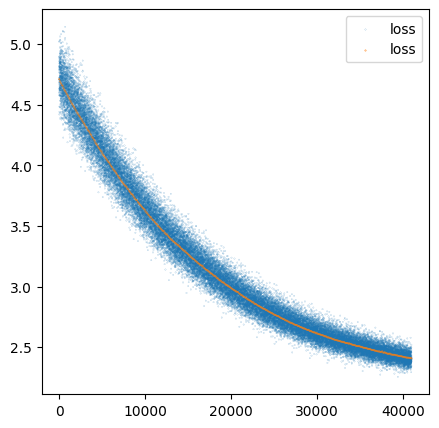

In [47]:
# Plot loss
plot.figure(figsize=(5, 5))
plot.scatter(range(len(train_loss_hist)),train_loss_hist, np.ones(len(train_loss_hist)) * 0.01, label='loss', alpha = 1)
plot.scatter(np.linspace(0,len(train_loss_hist),len(val_loss_hist)),val_loss_hist, np.ones(len(val_loss_hist)) * 0.1, label='loss', alpha = 1)
plot.savefig( loss_path + run_info + ".jpeg")
plot.legend()
plot.show()

In [ ]:
torch.save(test_data, test_data_path + "full_test_data_run_" + run_num_str+ "_"+ K_str + "flows_" + hidden_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs.pt")

### Evaluation

In [ ]:
min_time = min(inputs[:,4])
skipped = np.array([])

eval_batch_size = 1000
eval_max_iter = test_data.shape[0] // eval_batch_size
eval_test_data = test_data[:eval_max_iter * eval_batch_size]

eval_test_data.to('cpu')
model.to('cpu')
model.eval()
samples = torch.empty(eval_test_data.shape[0])
for i in tqdm(range(eval_max_iter)):
    begin = eval_batch_size * i
    end = eval_batch_size * (i + 1)
    samples[begin:end] = model.sample(num_samples = eval_batch_size, context = test_data[begin:end,:num_context])[0].cpu().detach().squeeze(1)
    

In [ ]:
for i in range(len(samples)):
    if(samples[i] < min_time):
        skipped = np.append(skipped, i)
for i in range(len(skipped) - 1):
    samples = torch.cat((samples[:int(skipped[i])],samples[int(skipped[i] + 1):int(skipped[i + 1])]))
model.train();

### Claude code no resampling, cut

In [30]:
min_time = min(inputs[:, 4])
eval_batch_size = 1000
eval_max_iter = test_data.shape[0] // eval_batch_size
eval_test_data = test_data[:eval_max_iter * eval_batch_size].to('cpu')
model.to('cpu')
model.eval()

samples = []
total_samples = 0
target_samples = eval_test_data.shape[0]

with torch.no_grad():
    pbar = tqdm(total=target_samples)
    while total_samples < target_samples:
        remaining = target_samples - total_samples
        batch_size = min(eval_batch_size, remaining)
        
        batch_samples = model.sample(num_samples=batch_size, 
                                     context=eval_test_data[total_samples:total_samples+batch_size, :num_context])[0]
        
        valid_samples = batch_samples[batch_samples.squeeze(1) >= min_time]
        samples.append(valid_samples)
        
        new_samples = valid_samples.shape[0]
        total_samples += new_samples
        pbar.update(new_samples)

    pbar.close()

samples = torch.cat(samples, dim=0)[:target_samples].squeeze(1)
model.train();

KeyboardInterrupt: 

### Claude code resampling, cut

In [ ]:
min_time = min(inputs[:, 4])
eval_batch_size = 1000
eval_max_iter = test_data.shape[0] // eval_batch_size
eval_test_data = test_data[:eval_max_iter * eval_batch_size].to('cpu')
model.to('cpu')
model.eval()

samples = torch.empty(eval_test_data.shape[0], 1)

with torch.no_grad():
    for i in tqdm(range(eval_max_iter)):
        begin = eval_batch_size * i
        end = eval_batch_size * (i + 1)
        batch_context = eval_test_data[begin:end, :num_context]
        
        batch_samples = model.sample(num_samples=eval_batch_size, context=batch_context)[0]
        valid_mask = batch_samples.squeeze(1) >= min_time
        
        while not valid_mask.all():
            invalid_indices = torch.where(~valid_mask)[0]
            resampled = model.sample(num_samples=len(invalid_indices), 
                                     context=batch_context[invalid_indices])[0]
            batch_samples[invalid_indices] = resampled
            valid_mask[invalid_indices] = resampled.squeeze(1) >= min_time
        
        samples[begin:end] = batch_samples
samples = samples.squeeze(1)
model.train();

In [3]:
# torch.save(samples,"data/samples/vary_p_uniform_6_hl_100_bs.pt")
# torch.save(eval_test_data,"data/test/vary_p_uniform_6_hl_100_bs.pt")

samples = torch.load("data/samples/vary_p_uniform_12_flows_8hl_64hu_100bs.pt")
eval_test_data = torch.load("data/test/vary_p_uniform_12_flows_8hl_64hu_100bs.pt")

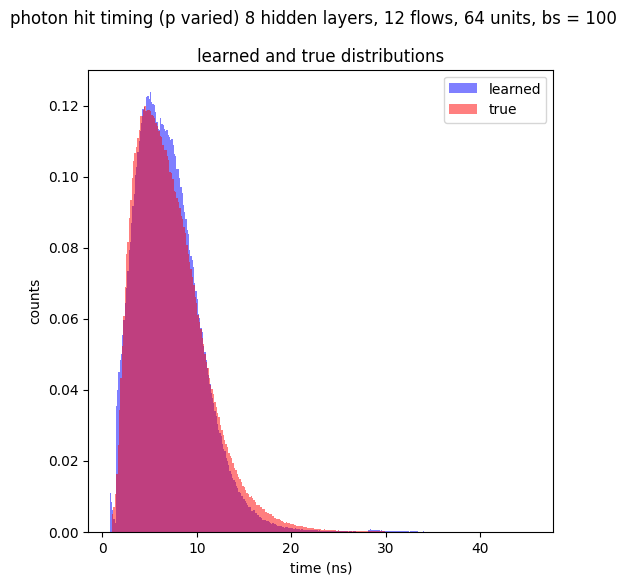

In [49]:
sample_fig, sample_axs = plot.subplots(1,1,figsize=(6,6))
sample_fig.suptitle("photon hit timing (p varied) 8 hidden layers, 12 flows, 64 units, bs = 100")
sample_axs.hist(samples,bins = 300, alpha = 0.5,color = 'b', label = 'learned', density = True)
sample_axs.set_title("learned and true distributions")
sample_axs.set_xlabel("time (ns)")
sample_axs.set_ylabel("counts")
sample_axs.hist(eval_test_data[:,num_context],bins = 300, color = 'r', alpha = 0.5, label = 'true', density = True)
sample_axs.legend(loc='upper right')
sample_fig.show()

In [50]:
sample_fig.savefig("plots/test_distributions/vary_p_uniform_12_flows_8hl_64hu_100bs_normalized_resample.pdf")